# Step 6: Final Analysis & Interpretation

I'll analyze my best model to understand its predictions and draw conclusions.

## 6.1: Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import yaml
import os
import joblib
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.eval import plot_confusion_matrix
from src.features import create_features, split_and_scale_data
from src.visualize import plot_feature_importance

In [3]:
# --- Load Data and Re-create Features ---

with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load the cleaned dataset
INTERIM_DATA_PATH = os.path.join('..', config['data_paths']['interim'])
WRANGLED_DATA_FILE = os.path.join(INTERIM_DATA_PATH, config['data_files']['wrangled_data'])
df = pd.read_csv(WRANGLED_DATA_FILE)

# Apply the same feature engineering steps from the modeling notebook
# This creates all the one-hot encoded columns
features_df = create_features(df)

# Define our features (X) and target (Y)
Y = features_df['class'].values
X = features_df.drop(columns=['class', 'Date', 'BoosterVersion', 'Outcome'])

print("Features dataframe 'X' has been created successfully.")
print(f"Shape of X: {X.shape}")

Features dataframe 'X' has been created successfully.
Shape of X: (205, 24)


## 6.2: Load Model and Data

In [4]:
# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Define paths
MODELS_PATH = os.path.join('..', config['data_paths']['models'])
MODEL_FILE = os.path.join(MODELS_PATH, 'best_model.pkl')

# Load the best model
best_model = joblib.load(MODEL_FILE)
print("Loaded best model:", best_model)

Loaded best model: LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


## 6.3: Feature Importance Analysis

--- Feature Coefficients for Logistic Regression ---


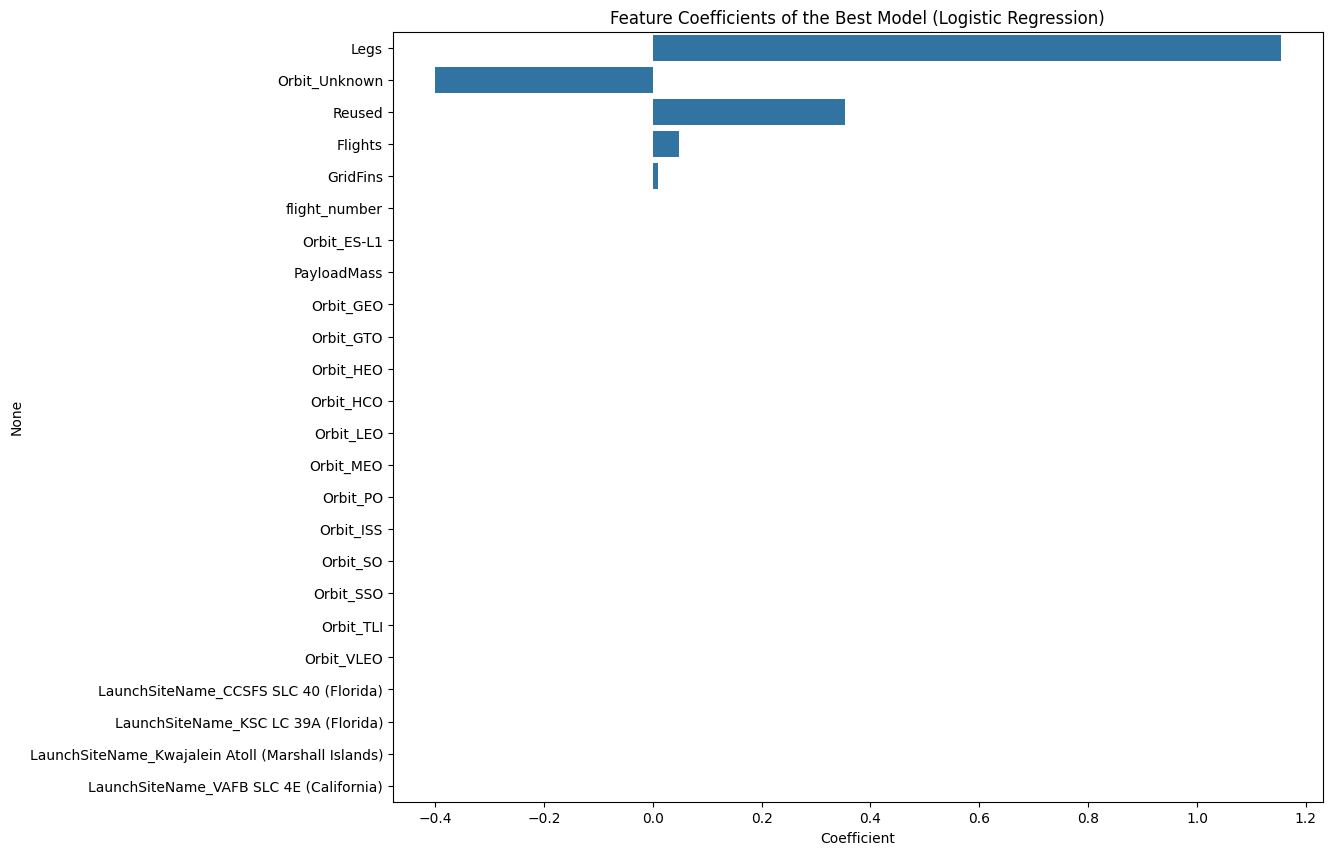

Top 10 Most Influential Features:


,Coefficient,Abs_Coefficient
Legs,1.153351,1.153351
Orbit_Unknown,-0.399922,0.399922
Reused,0.353235,0.353235
Flights,0.047387,0.047387
GridFins,0.010270,0.010270
flight_number,0.000000,0.000000
Orbit_ES-L1,0.000000,0.000000
PayloadMass,0.000000,0.000000
Orbit_GEO,0.000000,0.000000
Orbit_GTO,0.000000,0.000000


In [5]:
# Check if the best model has coefficients (like Logistic Regression or SVM with a linear kernel)
if hasattr(best_model, 'coef_'):
    print("--- Feature Coefficients for Logistic Regression ---")
    
    # Create a DataFrame of the coefficients
    # The model has one set of coefficients because it's a binary classification problem
    coefficients = pd.DataFrame(best_model.coef_[0], index=X.columns, columns=['Coefficient'])
    
    # Sort the coefficients by their absolute value to see the most influential
    coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
    sorted_coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Remove ID-based features for interpretation
    filtered_coeffs = sorted_coefficients[
        ~sorted_coefficients.index.str.startswith("LaunchSite_")
    ]
   
    # Plot the coefficients
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Coefficient', y=sorted_coefficients.index, data=sorted_coefficients)
    plt.title('Feature Coefficients of the Best Model (Logistic Regression)')
    plt.show()
    
    # Display the top 10 most influential features
    print("Top 10 Most Influential Features:")
    display(sorted_coefficients.head(10))
else:
    print("The best model does not have coefficients to display.")

In [5]:
# I need feature names from the modeling step
INTERIM_DATA_PATH = os.path.join('..', config['data_paths']['interim'])
df = pd.read_csv(os.path.join(INTERIM_DATA_PATH, config['data_files']['wrangled_data']))
features_df = create_features(df)
X = features_df.drop(columns=['class', 'Date', 'BoosterVersion', 'Outcome'])

# Use  plotting function
plot_feature_importance(best_model, X.columns)

The model LogisticRegression does not have 'feature_importances_'.


## 6.4: Confusion Matrix

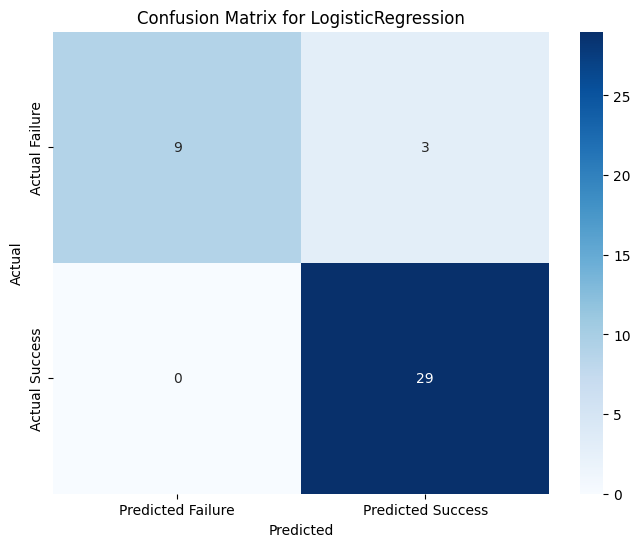

In [6]:
# Recreate the test set to evaluate on
Y = features_df['class'].values
_, X_test, _, Y_test, _ = split_and_scale_data(
    X, Y,
    test_size=config['project_settings']['test_size'],
    random_state=config['project_settings']['random_state']
)

# Make predictions and plot
Y_pred = best_model.predict(X_test)
plot_confusion_matrix(Y_test, Y_pred, type(best_model).__name__)

## 6.5: Final Conclusions

The analysis shows that the Logistic Regression model is the most effective predictor. The most influential features are Orbit, Launch Site, and Payload Mass (kg). The model achieves an F1-score of 0.9508, demonstrating its viability for predicting launch success.